In [1]:
import patchdata
import model
import test
import torch
import torch.optim as optim
import torch.nn as nn

img_size = 32
patch_size = 4
batch_size = 128
save_acc =50
epochs = 500
lr = 0.001
drop_rate = .1
weight_decay = 0
num_classes = 10
latent_vec_dim = 128
num_heads = 8
num_layers = 12
dataname = 'cifar10'
mode = 'train'
pretrained = 0

latent_vec_dim = latent_vec_dim
mlp_hidden_dim = int(latent_vec_dim/2)
num_patches = int((img_size * img_size) / (patch_size * patch_size))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Image Patches
d = patchdata.Flattened2Dpatches(dataname=dataname, img_size=img_size, patch_size=patch_size,
                                     batch_size=batch_size)
trainloader, valloader, testloader = d.patchdata()
image_patches, _ = iter(trainloader).next()


# Model
vit = model.VisionTransformer(patch_vec_size=image_patches.size(2), num_patches=image_patches.size(1),
                                latent_vec_dim=latent_vec_dim, num_heads=num_heads, mlp_hidden_dim=mlp_hidden_dim,
                                drop_rate=drop_rate, num_layers=num_layers, num_classes=num_classes).to(device)

Files already downloaded and verified
Files already downloaded and verified


In [16]:
# vit

In [3]:
vit.load_state_dict(torch.load('./model1.pth'))

<All keys matched successfully>

In [4]:
for img, labels in trainloader:
    outputs, _,_,_ = vit(img.to(device))
    break

In [5]:
print(outputs.shape,"\n\n",outputs)

torch.Size([128, 10]) 

 tensor([[ 1.7021,  4.0173, -4.8029,  ..., -4.3524, 13.4071,  7.7795],
        [-5.0680, -9.0061,  4.6456,  ...,  2.1985, -8.6600, -7.9288],
        [ 1.0605, -7.2080, 13.6703,  ..., -3.0755, -2.3723, -3.4219],
        ...,
        [ 9.2618,  3.8835, -3.4165,  ..., -3.1135,  5.7524,  5.9318],
        [-1.9843,  1.6008, -4.8547,  ..., -0.5202, -0.9865, -0.8206],
        [-1.6983,  1.4006,  0.7694,  ...,  1.4142, -5.7040, -0.5578]],
       device='cuda:0', grad_fn=<AddmmBackward0>)


In [6]:
print(labels.shape,"\n\n",labels)

torch.Size([128]) 

 tensor([8, 4, 2, 3, 1, 4, 3, 9, 2, 5, 4, 7, 2, 9, 4, 4, 5, 5, 9, 9, 1, 4, 2, 1,
        3, 9, 1, 2, 1, 1, 4, 2, 0, 2, 5, 7, 0, 4, 2, 0, 5, 4, 1, 2, 1, 2, 0, 9,
        0, 0, 7, 4, 3, 3, 2, 7, 7, 4, 0, 8, 1, 6, 3, 2, 5, 1, 9, 9, 8, 7, 2, 5,
        6, 9, 9, 1, 2, 9, 4, 7, 0, 6, 2, 4, 6, 1, 7, 6, 4, 7, 7, 1, 4, 2, 2, 5,
        3, 0, 7, 2, 3, 1, 4, 4, 7, 3, 8, 9, 9, 3, 0, 8, 1, 2, 5, 7, 5, 3, 8, 7,
        4, 3, 1, 5, 6, 0, 3, 6])


In [7]:
torch.argmax(outputs,1)

tensor([8, 4, 2, 5, 1, 4, 8, 9, 2, 5, 5, 7, 2, 9, 4, 4, 5, 5, 9, 9, 1, 4, 2, 1,
        4, 9, 1, 2, 1, 1, 7, 4, 0, 6, 5, 4, 0, 4, 2, 0, 5, 4, 1, 2, 1, 2, 0, 9,
        0, 0, 7, 4, 3, 3, 2, 7, 7, 4, 0, 8, 1, 6, 3, 2, 3, 1, 9, 9, 8, 7, 2, 5,
        6, 9, 1, 1, 2, 9, 4, 7, 0, 6, 2, 4, 6, 1, 7, 6, 4, 7, 7, 1, 4, 2, 2, 5,
        3, 0, 7, 2, 3, 9, 4, 4, 7, 5, 8, 9, 9, 3, 0, 8, 1, 2, 5, 7, 5, 3, 8, 7,
        4, 3, 1, 3, 6, 0, 3, 6], device='cuda:0')

In [8]:
# 모델 저장
# import torch.onnx
# torch.onnx.export(vit.to(device),img.to(device),'./vit.onnx',export_params=False,opset_version=12,
#                   operator_export_type=torch.onnx.OperatorExportTypes.ONNX_ATEN_FALLBACK)

In [9]:
outputs, _,ori,po = vit(img.to(device))


In [10]:
# 패치벡터 사이즈 48 => 3(채널)*4*4(각 패치 너비,높이 사이즈)를 1행으로 전개
# 패치 갯수 64 
# 레이턴트 벡터 디멘젼 128 

ori.shape

torch.Size([128, 64, 48])

In [11]:
po.shape

## 맨앞에는 시작 토큰때문에 패치갯수가 1나 늘음
## 패치 벡터사이즈가 48-> 128로 임베딩됨,선형 투영(liner projection) (포지션 임베딩 포함)


torch.Size([128, 65, 128])

Sample image size:  torch.Size([64, 3, 4, 4])


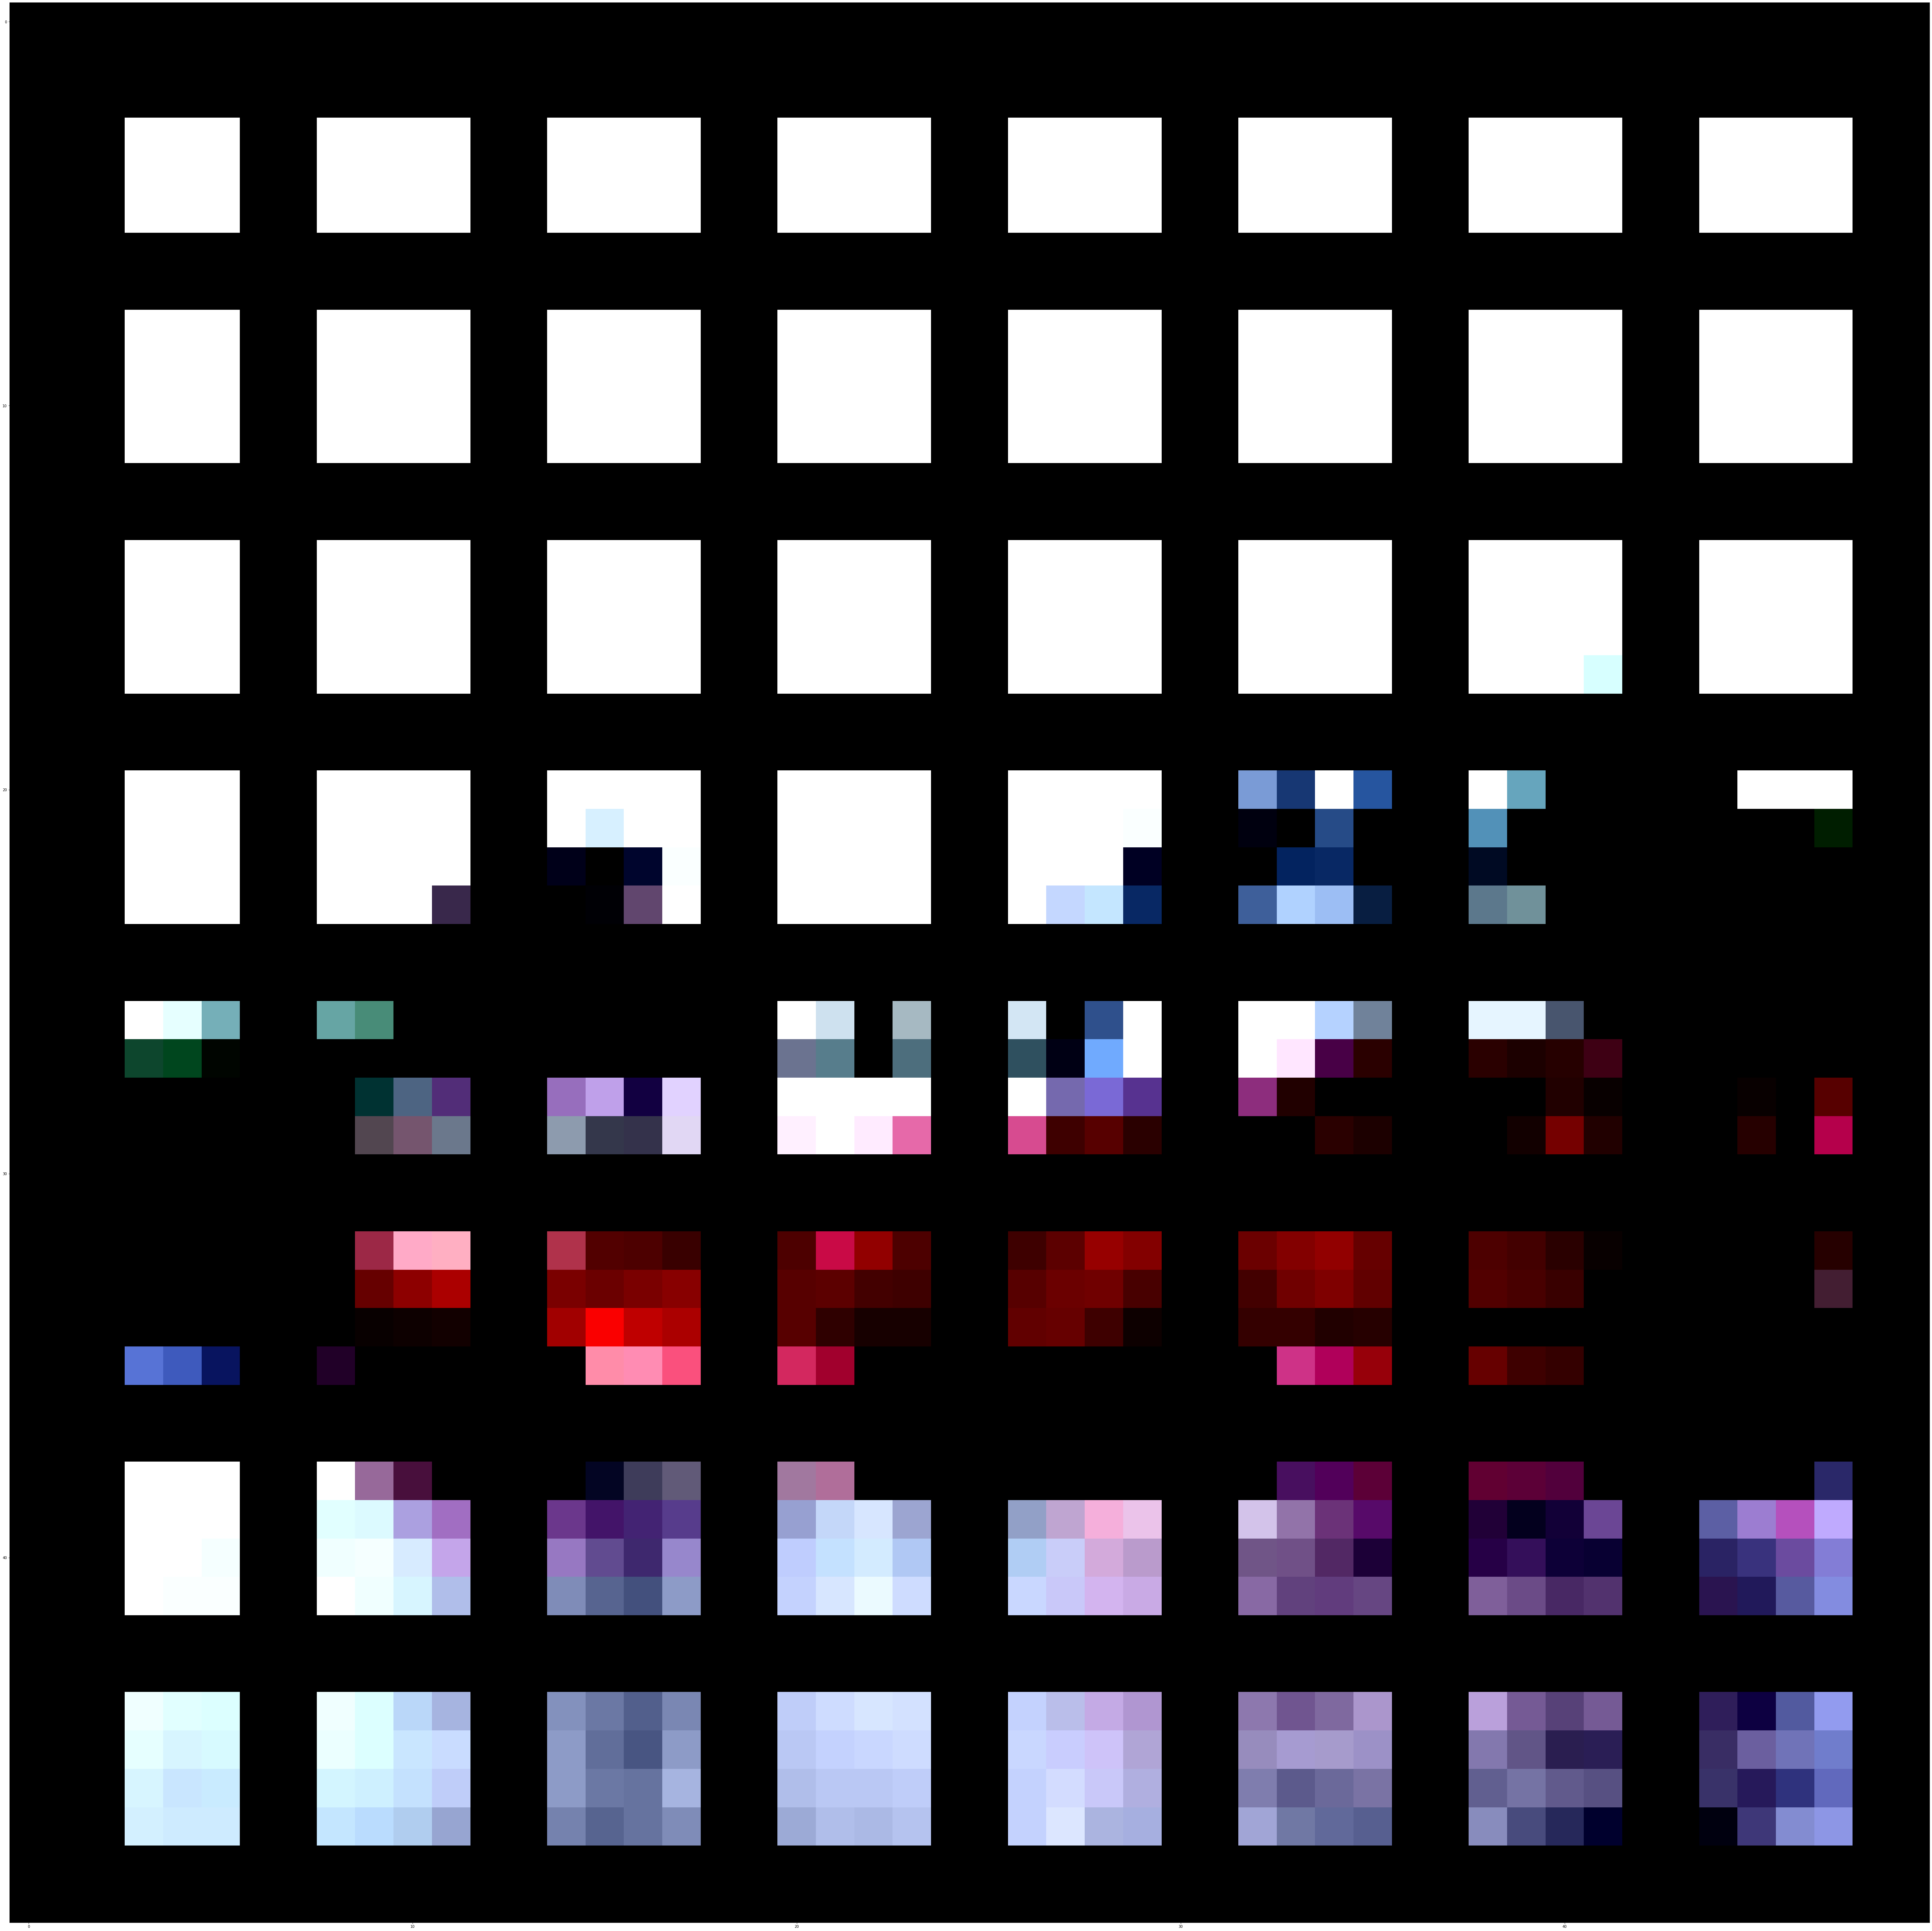

In [18]:
import matplotlib.pyplot as plt
import torchvision

def imshow(img):
    plt.figure(figsize=(100,100))
    plt.imshow(img.permute(1,2,0).numpy())
    plt.savefig('pacth_example.png')


sample = img.reshape(batch_size, num_patches, -1, patch_size, patch_size)[0]
imshow(torchvision.utils.make_grid(sample, nrow=int(img_size/patch_size)))

In [13]:
img.shape

torch.Size([128, 64, 48])